In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# """
# Created on Fri Sept 18 2020

# @author: AJay
# """

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers

import time

from scipy.stats.kde import gaussian_kde
from IPython import display
import matplotlib.pyplot as plt

Dimension of the problem and number of samples to generate.

In [5]:
dim, nsamples = 1, 1000

Create the generator and discriminator

In [6]:
def make_generator_model(dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(10, use_bias=True, input_shape=(dim,),activation='relu'))
    model.add(layers.Dense(10, use_bias=True, activation='relu'))
    model.add(layers.Dense(dim,use_bias=True))
    
    return model

generator = make_generator_model(dim)

def make_discriminator_model(dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(10, use_bias=True, input_shape=(dim,),activation='relu'))
    model.add(layers.Dense(10, use_bias=True, activation='relu'))
    model.add(layers.Dense(1,use_bias=True,activation='sigmoid'))

    return model

discriminator = make_discriminator_model(dim)

In [7]:
print('Generator: \n')
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=False, dpi=64)

Generator: 

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [8]:
print('Discriminator: \n')
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=False, dpi=64)

Discriminator: 

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


# **Prior to training**


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



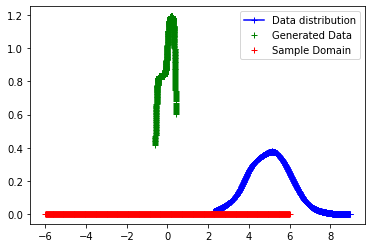

In [9]:
noise = np.linspace(-6,6,nsamples)
noise = np.reshape(noise,(nsamples,1))

data = np.random.normal(loc = 5, scale=1,size = nsamples)

plt.figure()

kde_data = gaussian_kde(data)
data_space = np.linspace(min(data),max(data),1000)
plt.plot(data_space,kde_data(data_space),'-b+',label="Data distribution")

generated_data = generator(noise,training=False)
kde_generated = gaussian_kde(np.squeeze(generated_data.numpy()))
generated_space = np.squeeze(np.linspace(min(generated_data),max(generated_data),1000))
plt.plot(generated_space,kde_generated(generated_space),'g+',label="Generated Data")

plt.plot(noise,(1/nsamples)*np.ones_like(noise),'r+',label="Sample Domain")
plt.legend()

#**Losses and Optimizers**

Losses for both the networks are Binary Cross Entropy. 


*   Cost function for discriminator is


> $$J^{(D)}(\theta^{(D)},\theta^{(G)}) = \mathbb{E}_{x \sim p_{data}}\log D(x)+\mathbb{E}_{z}\log (1-D(G(z)))$$


*   There are two possibilities for the losses of generator


>**1. Minmax game**
>> Simplest version, we consider
    $$J^{(G)} = J^{(D)}$$
    We can summarize by defining a value function as
    $$ V(\theta^{(D)},\theta^{(G)}) = J^{(D)}(\theta^{(D)},\theta^{(G)})$$ and thus
    $$\theta^{(G)*}, \theta^{(D)*} = \arg\min_{\theta^{(G)}}\max_{\theta^{(D)}}V(\theta^{(D)},\theta^{(G)})$$



>  **2. Heuristic, non- saturating game**
>>The cost mentioned above is useful for theoretical analysis, but does not work well in practice as the generator's gradient vanishes when the discriminator rejects sample with high confidence. Hence we define the cost for generator as 
$$J^{(G)} = \mathbb{E}_{z} \log D(G(z))$$

















In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # total_loss = real_loss + fake_loss
    return real_loss, fake_loss

def generator_loss(fake_output):
    return cross_entropy(0.9*tf.ones_like(fake_output), fake_output)

In [11]:
def opt(lr, decay_steps=100, decay_rate=0.95, staircase=True, name=None):
  lr = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100, decay_rate=0.95, staircase=True, name=None)
  return tf.keras.optimizers.SGD(learning_rate=lr)

In [12]:
lr = 0.01
generator_optimizer = opt(lr=lr/2)
discriminator_optimizer = opt(lr=lr)

#**Training**

**Training parameters**

One step of training defined as train_step. Called by the train function defined further below.

In [13]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step():
      # Sample noise
      noise = np.linspace(-6,6,nsamples)
      noise = np.reshape(noise,(nsamples,1))
      # Sample real data
      samples = np.random.normal(loc=5,scale=1,size=(nsamples,dim))
      samples.sort()

      # Generate samples from noise
      generated_samples = generator(noise, training=False)
      with tf.GradientTape() as disc_tape:
        real_output = discriminator(samples, training=True)
        fake_output = discriminator(generated_samples, training=True)

        real_loss, fake_loss = discriminator_loss(real_output,fake_output)
        total_disc_loss = real_loss+fake_loss

      gradients_of_discriminator = disc_tape.gradient(total_disc_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

      with tf.GradientTape() as gen_tape:
        generated_samples = generator(noise, training=True)
        fake_output = discriminator(generated_samples, training=False)

        gen_loss = generator_loss(fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      
      return gen_loss, real_loss, fake_loss

Function to train both the networks. 
  Executes one step of training defined by train_step for the number of epochs

In [14]:
def train(epochs):

  gen_loss_array = [] #defining empty arrays to store the losses
  disc_real_loss_array = []
  disc_fake_loss_array = []
  for epoch in range(epochs):   
    gen_loss, disc_real_loss, disc_fake_loss = train_step() #Executing one step of training
        
    gen_loss_array.append(gen_loss.numpy())
    disc_real_loss_array.append(disc_real_loss.numpy())
    disc_fake_loss_array.append(disc_fake_loss.numpy())

  return gen_loss_array, disc_real_loss_array, disc_fake_loss_array

**Train** the network for the given input data and **EPOCHS**

In [15]:
EPOCHS = 2500

In [16]:
#Train the networks for the given 
gen_loss, disc_real_loss, disc_fake_loss = train(EPOCHS)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



#Plotting

Plot the Generator and Discriminator losses.

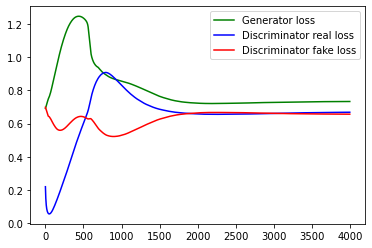

In [17]:
plt.figure()
plt.plot(gen_loss,'g',label='Generator loss')
plt.plot(disc_real_loss,'b',label='Discriminator real loss')
plt.plot(disc_fake_loss,'r',label='Discriminator fake loss')
plt.legend()

Plot the training and generated samples.

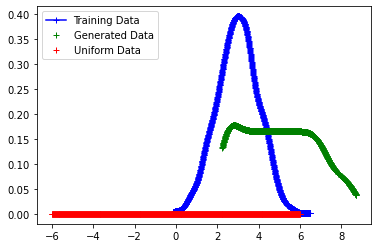

In [18]:
sample_uniform = np.linspace(-6,6,nsamples)
sample_uniform = np.reshape(sample_uniform,(nsamples,1))

sample_normal = np.random.normal(loc = 3, scale=1,size = nsamples)

plt.figure()

kde_normal = gaussian_kde(sample_normal)
s_space = np.linspace(min(sample_normal),max(sample_normal),1000)
plt.plot(s_space,kde_normal(s_space),'-b+',label="Training Data")

generated_sample = generator(sample_uniform,training=False)
kde_generated = gaussian_kde(np.squeeze(generated_sample.numpy()))
s_sample = np.squeeze(np.linspace(min(generated_sample),max(generated_sample),1000))
plt.plot(s_sample,kde_generated(s_sample),'g+',label="Generated Data")

plt.plot(sample_uniform,(1/nsamples)*np.ones_like(sample_uniform),'r+',label="Uniform Data")
plt.legend()

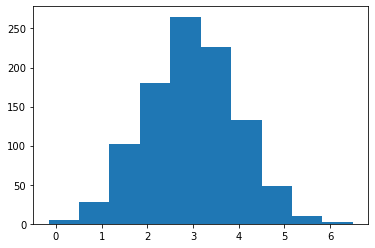

In [19]:
_ = plt.hist(sample_normal)

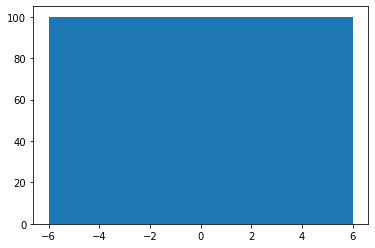

In [20]:
_ = plt.hist(sample_uniform)

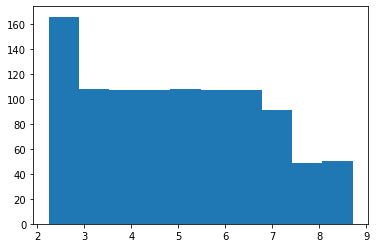

In [21]:
_ = plt.hist(generated_sample.numpy())